# Fraud Detection - Feature Engineering

This notebook focuses on creating meaningful features from raw data to improve fraud detection model performance.

## Objectives:
1. Create time-based features from timestamps
2. Map IP addresses to countries for geolocation analysis
3. Engineer transaction pattern features
4. Create user behavior and device pattern features
5. Handle categorical variables encoding
6. Prepare data for machine learning models

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import ipaddress
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
import pickle

warnings.filterwarnings('ignore')
np.random.seed(42)

## 1. Load Data and Previous Insights

In [2]:
# Load datasets
fraud_data = pd.read_csv('../Data/Fraud_Data.csv')
ip_country = pd.read_csv('../Data/IpAddress_to_Country.csv')
creditcard_data = pd.read_csv('../Data/creditcard.csv')

# Load EDA insights
try:
    with open('../results/eda_insights.pkl', 'rb') as f:
        eda_insights = pickle.load(f)
    print("EDA insights loaded successfully")
except FileNotFoundError:
    print("EDA insights not found. Please run 01_data_exploration.ipynb first.")
    eda_insights = {}

print(f"Fraud data shape: {fraud_data.shape}")
print(f"Credit card data shape: {creditcard_data.shape}")
print(f"IP country data shape: {ip_country.shape}")

EDA insights loaded successfully
Fraud data shape: (151112, 11)
Credit card data shape: (284807, 31)
IP country data shape: (138846, 3)


## 2. Fraud Data Feature Engineering

In [3]:
# Create a copy for feature engineering
fraud_features = fraud_data.copy()

# Convert timestamp columns to datetime
fraud_features['signup_time'] = pd.to_datetime(fraud_features['signup_time'])
fraud_features['purchase_time'] = pd.to_datetime(fraud_features['purchase_time'])

print("Timestamp conversion completed")

Timestamp conversion completed


In [4]:
# 2.1 Time-based Features

# Time since signup (in hours)
fraud_features['time_since_signup'] = (fraud_features['purchase_time'] - fraud_features['signup_time']).dt.total_seconds() / 3600

# Purchase time features
fraud_features['purchase_hour'] = fraud_features['purchase_time'].dt.hour
fraud_features['purchase_day_of_week'] = fraud_features['purchase_time'].dt.dayofweek
fraud_features['purchase_month'] = fraud_features['purchase_time'].dt.month
fraud_features['purchase_day_of_month'] = fraud_features['purchase_time'].dt.day

# Signup time features
fraud_features['signup_hour'] = fraud_features['signup_time'].dt.hour
fraud_features['signup_day_of_week'] = fraud_features['signup_time'].dt.dayofweek

# Time-based patterns
fraud_features['is_weekend_purchase'] = fraud_features['purchase_day_of_week'].isin([5, 6]).astype(int)
fraud_features['is_night_purchase'] = fraud_features['purchase_hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
fraud_features['is_business_hours'] = fraud_features['purchase_hour'].isin(range(9, 18)).astype(int)

# Quick purchase (purchased within 1 hour of signup)
fraud_features['quick_purchase'] = (fraud_features['time_since_signup'] <= 1).astype(int)

print("Time-based features created")

Time-based features created


In [5]:
# 2.2 IP Address to Country Mapping

def ip_to_int(ip_str):
    """Convert IP address string to integer"""
    try:
        return int(ipaddress.IPv4Address(ip_str))
    except:
        return None

def map_ip_to_country(ip_int, ip_country_df):
    """Map IP integer to country using IP ranges"""
    if pd.isna(ip_int):
        return 'Unknown'
    
    # Find the country for this IP
    mask = (ip_country_df['lower_bound_ip_address'] <= ip_int) & (ip_int <= ip_country_df['upper_bound_ip_address'])
    result = ip_country_df[mask]
    
    if len(result) > 0:
        return result.iloc[0]['country']
    else:
        return 'Unknown'

# Convert IP addresses to integers (assuming they're already in numeric format)
fraud_features['ip_address_int'] = fraud_features['ip_address']

# Map to countries (this might take a while for large datasets)
print("Mapping IP addresses to countries...")
fraud_features['country'] = fraud_features['ip_address_int'].apply(
    lambda x: map_ip_to_country(x, ip_country)
)

print(f"Country mapping completed. Found {fraud_features['country'].nunique()} unique countries")

Mapping IP addresses to countries...
Country mapping completed. Found 182 unique countries


In [6]:
# 2.3 User and Device Pattern Features

# Age groups
fraud_features['age_group'] = pd.cut(fraud_features['age'], 
                                    bins=[0, 25, 35, 45, 55, 100], 
                                    labels=['18-25', '26-35', '36-45', '46-55', '55+'])

# Purchase value categories
fraud_features['purchase_value_category'] = pd.cut(fraud_features['purchase_value'],
                                                  bins=[0, 20, 50, 100, 500, float('inf')],
                                                  labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Device and browser risk scores (based on fraud rates)
device_fraud_rate = fraud_features.groupby('device_id')['class'].mean()
browser_fraud_rate = fraud_features.groupby('browser')['class'].mean()
source_fraud_rate = fraud_features.groupby('source')['class'].mean()

fraud_features['device_risk_score'] = fraud_features['device_id'].map(device_fraud_rate)
fraud_features['browser_risk_score'] = fraud_features['browser'].map(browser_fraud_rate)
fraud_features['source_risk_score'] = fraud_features['source'].map(source_fraud_rate)

print("User and device pattern features created")

User and device pattern features created


In [7]:
# 2.4 Transaction Velocity Features

# Sort by user and time for velocity calculations
fraud_features_sorted = fraud_features.sort_values(['user_id', 'purchase_time'])

# Count of transactions per user
user_transaction_count = fraud_features_sorted.groupby('user_id').size()
fraud_features['user_transaction_count'] = fraud_features['user_id'].map(user_transaction_count)

# Average purchase value per user
user_avg_purchase = fraud_features_sorted.groupby('user_id')['purchase_value'].mean()
fraud_features['user_avg_purchase_value'] = fraud_features['user_id'].map(user_avg_purchase)

# Deviation from user's average purchase
fraud_features['purchase_deviation_from_avg'] = (
    fraud_features['purchase_value'] - fraud_features['user_avg_purchase_value']
) / fraud_features['user_avg_purchase_value']

print("Transaction velocity features created")

Transaction velocity features created


## 3. Credit Card Data Feature Engineering

In [8]:
# Create a copy for feature engineering
cc_features = creditcard_data.copy()

# 3.1 Time-based Features
# Convert time to hours and create time-based features
cc_features['time_hours'] = cc_features['Time'] / 3600
cc_features['time_days'] = cc_features['Time'] / (3600 * 24)

# Hour of day (assuming Time=0 is midnight)
cc_features['hour_of_day'] = (cc_features['Time'] / 3600) % 24
cc_features['hour_of_day'] = cc_features['hour_of_day'].astype(int)

# Day of dataset (which day since start)
cc_features['day_of_dataset'] = (cc_features['Time'] / (3600 * 24)).astype(int)

# Time-based patterns
cc_features['is_night_transaction'] = cc_features['hour_of_day'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
cc_features['is_business_hours'] = cc_features['hour_of_day'].isin(range(9, 18)).astype(int)
cc_features['is_weekend'] = (cc_features['day_of_dataset'] % 7).isin([5, 6]).astype(int)

print("Credit card time-based features created")

Credit card time-based features created


In [9]:
# 3.2 Amount-based Features

# Log transformation of amount (to handle skewness)
cc_features['log_amount'] = np.log1p(cc_features['Amount'])

# Amount categories
cc_features['amount_category'] = pd.cut(cc_features['Amount'],
                                       bins=[0, 10, 50, 100, 500, float('inf')],
                                       labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Z-score of amount (standardized)
cc_features['amount_zscore'] = (cc_features['Amount'] - cc_features['Amount'].mean()) / cc_features['Amount'].std()

# High amount flag (top 5% of transactions)
amount_95th = cc_features['Amount'].quantile(0.95)
cc_features['high_amount_flag'] = (cc_features['Amount'] > amount_95th).astype(int)

print("Credit card amount-based features created")

Credit card amount-based features created


In [10]:
# 3.3 PCA Feature Engineering

# Get V features
v_features = [col for col in cc_features.columns if col.startswith('V')]

# Create feature combinations (top correlated features)
# Based on EDA insights, create interactions between highly correlated V features
if 'top_correlated_features' in eda_insights:
    top_features = list(eda_insights['top_correlated_features'].keys())[:5]
    
    # Create interaction features
    for i, feat1 in enumerate(top_features):
        for feat2 in top_features[i+1:]:
            cc_features[f'{feat1}_{feat2}_interaction'] = cc_features[feat1] * cc_features[feat2]

# Statistical features from V components
cc_features['v_features_mean'] = cc_features[v_features].mean(axis=1)
cc_features['v_features_std'] = cc_features[v_features].std(axis=1)
cc_features['v_features_max'] = cc_features[v_features].max(axis=1)
cc_features['v_features_min'] = cc_features[v_features].min(axis=1)
cc_features['v_features_range'] = cc_features['v_features_max'] - cc_features['v_features_min']

print("Credit card PCA feature engineering completed")

Credit card PCA feature engineering completed


## 4. Categorical Encoding

In [11]:
# 4.1 Fraud Data Categorical Encoding with Category Handling

categorical_cols = ['source', 'browser', 'sex', 'age_group', 'purchase_value_category', 'country']

# Make sure fraud_features is defined
try:
    fraud_features
except NameError:
    fraud_features = fraud_data.copy()

for col in categorical_cols:
    if col in fraud_features.columns:
        if pd.api.types.is_categorical_dtype(fraud_features[col]):
            # Add 'Unknown' to categories if not present
            if 'Unknown' not in fraud_features[col].cat.categories:
                fraud_features[col] = fraud_features[col].cat.add_categories('Unknown')
        # Fill missing values
        fraud_features[col] = fraud_features[col].fillna('Unknown')
    else:
        print(f"⚠️ Warning: Column '{col}' not found in fraud_features")

# One-hot encode existing categorical columns
fraud_encoded = pd.get_dummies(
    fraud_features,
    columns=[col for col in categorical_cols if col in fraud_features.columns],
    prefix=categorical_cols
)

print(f"Fraud data shape before encoding: {fraud_features.shape}")
print(f"Fraud data shape after encoding: {fraud_encoded.shape}")


Fraud data shape before encoding: (151112, 32)
Fraud data shape after encoding: (151112, 230)


In [12]:
# 4.2 Credit Card Data Categorical Encoding

# One-hot encode categorical variables
cc_categorical_cols = ['amount_category']

# Create dummy variables
cc_encoded = pd.get_dummies(cc_features, columns=cc_categorical_cols, prefix=cc_categorical_cols)

print(f"Credit card data shape after encoding: {cc_encoded.shape}")

Credit card data shape after encoding: (284807, 61)


## 5. Feature Selection and Preparation

In [13]:
# 5.1 Fraud Data Feature Selection

# Remove original timestamp and identifier columns
fraud_drop_cols = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'ip_address_int']
fraud_ml_ready = fraud_encoded.drop(columns=fraud_drop_cols, errors='ignore')

# Separate features and target
X_fraud = fraud_ml_ready.drop('class', axis=1)
y_fraud = fraud_ml_ready['class']

print(f"Fraud data - Features shape: {X_fraud.shape}, Target shape: {y_fraud.shape}")

Fraud data - Features shape: (151112, 223), Target shape: (151112,)


In [14]:
# 5.2 Credit Card Data Feature Selection

# Remove original Time column (we have engineered time features)
cc_ml_ready = cc_encoded.drop(columns=['Time'], errors='ignore')

# Separate features and target
X_creditcard = cc_ml_ready.drop('Class', axis=1)
y_creditcard = cc_ml_ready['Class']

print(f"Credit card data - Features shape: {X_creditcard.shape}, Target shape: {y_creditcard.shape}")

Credit card data - Features shape: (284807, 59), Target shape: (284807,)


## 6. Data Scaling and Train-Test Split

In [15]:
# 6.1 Handle missing values

# Fill missing values with median for numerical columns
X_fraud = X_fraud.fillna(X_fraud.median())
X_creditcard = X_creditcard.fillna(X_creditcard.median())

print("Missing values handled")

Missing values handled


In [16]:
# 6.2 Train-Test Split

# Fraud data split
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

# Credit card data split
X_cc_train, X_cc_test, y_cc_train, y_cc_test = train_test_split(
    X_creditcard, y_creditcard, test_size=0.2, random_state=42, stratify=y_creditcard
)

print("Train-test split completed:")
print(f"Fraud - Train: {X_fraud_train.shape}, Test: {X_fraud_test.shape}")
print(f"Credit Card - Train: {X_cc_train.shape}, Test: {X_cc_test.shape}")

Train-test split completed:
Fraud - Train: (120889, 223), Test: (30223, 223)
Credit Card - Train: (227845, 59), Test: (56962, 59)


In [17]:
# 6.3 Feature Scaling

# Initialize scalers
scaler_fraud = StandardScaler()
scaler_cc = StandardScaler()

# Fit and transform training data
X_fraud_train_scaled = scaler_fraud.fit_transform(X_fraud_train)
X_fraud_test_scaled = scaler_fraud.transform(X_fraud_test)

X_cc_train_scaled = scaler_cc.fit_transform(X_cc_train)
X_cc_test_scaled = scaler_cc.transform(X_cc_test)

# Convert back to DataFrames for easier handling
X_fraud_train_scaled = pd.DataFrame(X_fraud_train_scaled, columns=X_fraud_train.columns, index=X_fraud_train.index)
X_fraud_test_scaled = pd.DataFrame(X_fraud_test_scaled, columns=X_fraud_test.columns, index=X_fraud_test.index)

X_cc_train_scaled = pd.DataFrame(X_cc_train_scaled, columns=X_cc_train.columns, index=X_cc_train.index)
X_cc_test_scaled = pd.DataFrame(X_cc_test_scaled, columns=X_cc_test.columns, index=X_cc_test.index)

print("Feature scaling completed")

Feature scaling completed


## 7. Feature Importance Analysis

In [18]:
# 7.1 Correlation Analysis

# Fraud data correlation with target
fraud_correlations = X_fraud_train.corrwith(y_fraud_train).abs().sort_values(ascending=False)

print("Top 15 features correlated with fraud (E-commerce):")
print(fraud_correlations.head(15))

# Credit card data correlation with target
cc_correlations = X_cc_train.corrwith(y_cc_train).abs().sort_values(ascending=False)

print("\nTop 15 features correlated with fraud (Credit Card):")
print(cc_correlations.head(15))

Top 15 features correlated with fraud (E-commerce):
device_risk_score        0.932808
quick_purchase           0.715813
purchase_month           0.312849
time_since_signup        0.259748
purchase_day_of_month    0.161330
source_risk_score        0.022628
source_Direct            0.022036
country_Luxembourg       0.020186
country_Ireland          0.019394
purchase_day_of_week     0.018644
country_Ecuador          0.017181
country_New Zealand      0.016553
browser_risk_score       0.016138
country_Namibia          0.015344
country_Saudi Arabia     0.014930
dtype: float64

Top 15 features correlated with fraud (Credit Card):
V14_V12_interaction    0.581662
V12_V10_interaction    0.550084
V14_V16_interaction    0.543644
V17_V12_interaction    0.542743
V17_V16_interaction    0.542241
V17_V14_interaction    0.539683
V12_V16_interaction    0.534268
V17_V10_interaction    0.531597
V14_V10_interaction    0.524067
V10_V16_interaction    0.516727
V17                    0.321937
v_features_mean  

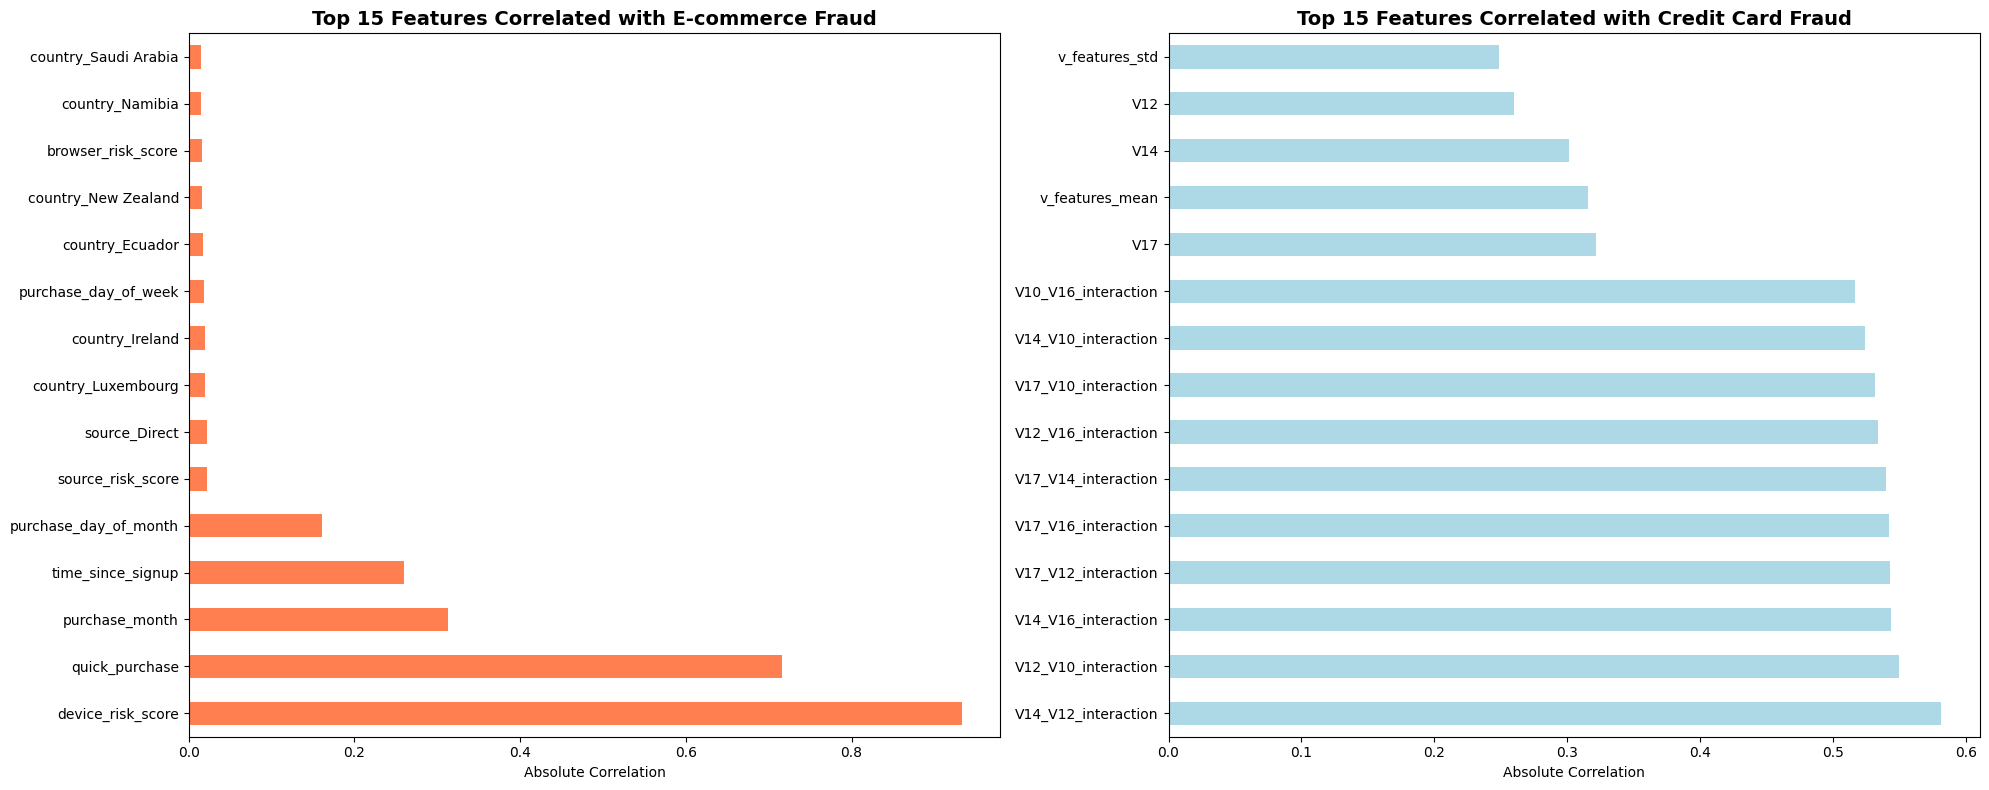

In [19]:
# 7.2 Visualize Feature Correlations

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Fraud data top correlations
fraud_correlations.head(15).plot(kind='barh', ax=axes[0], color='coral')
axes[0].set_title('Top 15 Features Correlated with E-commerce Fraud', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Absolute Correlation')

# Credit card data top correlations
cc_correlations.head(15).plot(kind='barh', ax=axes[1], color='lightblue')
axes[1].set_title('Top 15 Features Correlated with Credit Card Fraud', fontweight='bold', fontsize=14)
axes[1].set_xlabel('Absolute Correlation')

plt.tight_layout()
plt.show()

## 8. Save Processed Data

In [20]:
# Save all processed datasets and scalers

# Create results directory if it doesn't exist
import os
os.makedirs('../results', exist_ok=True)

# Save fraud data
X_fraud_train_scaled.to_csv('../results/X_fraud_train_scaled.csv', index=False)
X_fraud_test_scaled.to_csv('../results/X_fraud_test_scaled.csv', index=False)
y_fraud_train.to_csv('../results/y_fraud_train.csv', index=False)
y_fraud_test.to_csv('../results/y_fraud_test.csv', index=False)

# Save credit card data
X_cc_train_scaled.to_csv('../results/X_cc_train_scaled.csv', index=False)
X_cc_test_scaled.to_csv('../results/X_cc_test_scaled.csv', index=False)
y_cc_train.to_csv('../results/y_cc_train.csv', index=False)
y_cc_test.to_csv('../results/y_cc_test.csv', index=False)

# Save scalers
with open('../results/scaler_fraud.pkl', 'wb') as f:
    pickle.dump(scaler_fraud, f)

with open('../results/scaler_cc.pkl', 'wb') as f:
    pickle.dump(scaler_cc, f)

# Save feature names
feature_info = {
    'fraud_features': list(X_fraud_train.columns),
    'cc_features': list(X_cc_train.columns),
    'fraud_correlations': fraud_correlations.to_dict(),
    'cc_correlations': cc_correlations.to_dict()
}

with open('../results/feature_info.pkl', 'wb') as f:
    pickle.dump(feature_info, f)

print("All processed data and feature information saved to results/ directory")
print(f"Fraud dataset: {X_fraud_train_scaled.shape[1]} features")
print(f"Credit card dataset: {X_cc_train_scaled.shape[1]} features")

All processed data and feature information saved to results/ directory
Fraud dataset: 223 features
Credit card dataset: 59 features


## 9. Feature Engineering Summary

### Created Features:

#### E-commerce Fraud Data:
1. **Time-based Features**: time_since_signup, purchase_hour, day_of_week, weekend/night flags
2. **Geolocation Features**: IP to country mapping
3. **User Behavior**: age_groups, purchase_value_categories, quick_purchase flag
4. **Risk Scores**: device_risk_score, browser_risk_score, source_risk_score
5. **Transaction Patterns**: user_transaction_count, deviation_from_average

#### Credit Card Data:
1. **Time-based Features**: hour_of_day, day_of_dataset, business_hours flags
2. **Amount Features**: log_amount, amount_categories, z-scores, high_amount_flag
3. **PCA Interactions**: feature combinations, statistical aggregations

### Data Preparation:
- Categorical encoding using one-hot encoding
- Feature scaling using StandardScaler
- Train-test split with stratification
- Missing value imputation

### Next Steps:
- Model training and evaluation
- Handling class imbalance
- Model interpretation and explainability

## 4. Fraud Data Analysis

This section explores the e-commerce dataset (`Fraud_Data.csv`), analyzing numerical features (`purchase_value`, `age`) and categorical features (`source`, `browser`, `sex`). We visualize distributions and fraud rates to identify patterns.